In [1]:
using CSV, DataFrames
using LinearAlgebra
using PyPlot
using Test
using Printf
using Statistics
using Combinatorics
using Colors
using ColorTypes

In [2]:
#Have an GUI plot window pop up
pygui(false)

false

In [3]:
#Read in MOFs

_df_henry = CSV.read("../data/henry_coefs_v4.csv")
#_df_henry = CSV.read("../data/Expt_Henry_Coeffs_v3_without_SIFSIX.csv")
for (i, xtal) in enumerate(_df_henry[:crystal])
    # Check replace() out for string replacement
    _df_henry[i, :crystal] = split(split(_df_henry[i, :crystal], ".cif")[1], "_")[1]
end
dropmissing!(_df_henry)
global const df_henry = deepcopy(_df_henry)

┌ Warning: dropmissing! will change eltype of cols to disallow missing by default. Use dropmissing!(df, cols, disallowmissing=false) to retain missing.
│   caller = dropmissing!(::DataFrame) at abstractdataframe.jl:733
└ @ DataFrames /home/sturlusa/.julia/packages/DataFrames/z2XOB/src/abstractdataframe/abstractdataframe.jl:733


,crystal,CO2_henry coefficient [mmol/(g-bar)],Temperature [K],SO2_henry coefficient [mmol/(g-bar)],Temperature [K]_1
,String⍰,Float64⍰,Int64⍰,Float64⍰,Int64⍰
1,MFM601,1.3703,298,97.2407,298
2,SIFSIX-3-Ni,998.247,298,367.978,298
3,Zn-bdc-ted,2.15867,298,19.1696,298
4,Ni-bdc-ted,2.2069,298,40.402,298
5,NOTT-202a,3.27573,293,153.6,293
6,SIFSIX-2-Cu-i,16.1738,298,4108.77,298
7,MFM600,1.41883,298,34.7973,298
8,SIFSIX-1-Cu,4.65771,298,405.418,298
9,SIFSIX-3-Zn,111.994,298,469.906,298


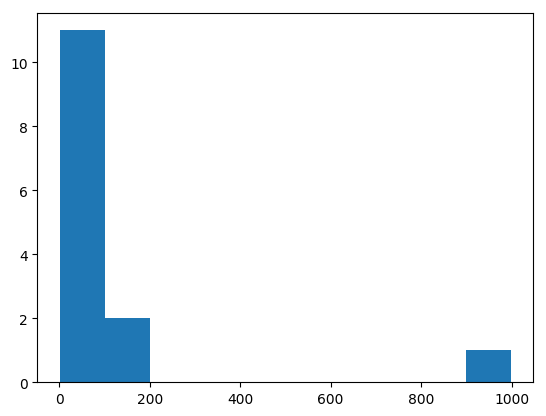

([11.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.3703, 101.058, 200.746, 300.433, 400.121, 499.809, 599.497, 699.184, 798.872, 898.56, 998.247], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7efe0c1ca4e0>, PyObject <matplotlib.patches.Rectangle object at 0x7efe0c1ca2e8>, PyObject <matplotlib.patches.Rectangle object at 0x7efe0c1ca828>, PyObject <matplotlib.patches.Rectangle object at 0x7efe0c1cab70>, PyObject <matplotlib.patches.Rectangle object at 0x7efe0c1caeb8>, PyObject <matplotlib.patches.Rectangle object at 0x7efe0c1d7278>, PyObject <matplotlib.patches.Rectangle object at 0x7efe0c1d75f8>, PyObject <matplotlib.patches.Rectangle object at 0x7efe0c1d7978>, PyObject <matplotlib.patches.Rectangle object at 0x7efe0c1d7cf8>, PyObject <matplotlib.patches.Rectangle object at 0x7efe0c1dd0b8>])

In [4]:
data = df_henry[Symbol("CO2_henry coefficient [mmol/(g-bar)]")]
plt[:hist](data)

In [5]:
function plot_histogram()
    fig = figure(figsize=(10,8))
    gases = ["CO2", "C2H6", "CH4", "H2S"]
    gas_labels = [L"CO$_2$", L"C$_2$H$_6$", L"CH$_4$", L"H$_2$S"]
    gas_textures = ["+", "O", "/", "*"]
    bin_size = 1.35
    maximum_value = maximum([maximum(df_henry[Symbol(gases[i] * "_henry coefficient [mmol/(g-bar)]")]) for i = 1:length(gases)])
    print(typeof(maximum_value))
    for (i, gas) in enumerate(gases)
        plt[:hist](df_henry[Symbol(gas * "_henry coefficient [mmol/(g-bar)]")], label=gas_labels[i],
            alpha=0.65, bins=range(0, stop=maximum_value + bin_size, step=bin_size), hatch=gas_textures[i])
    end
    legend()
    # grid()
    xlabel("Henry Coeffecient (mmol/(g-bar))")
    ylabel("Number of MOFs")
    title("")
    
end
#plot_histogram()

plot_histogram (generic function with 1 method)

In [6]:
function perform_svd(gas1::AbstractString, gas2::AbstractString)
    #Should we create the program for comparing just two MOFs?
    #Or should it be able to compare 3 as well?

    # MOFs[1] indicates the length of the first column, eg. the number of MOFs being screened
    #initialize Henry's Matrix
    N = size(df_henry)[1]
    sigma = zeros(N, N, 2)

    for i = 1:N
        for j = i+1:N
            H = make_h_matrix(i, j, gas1, gas2)
            F = svd(H)
            sigma[i, j, :] = F.S
        end
    end
    return sigma
end

perform_svd (generic function with 1 method)

In [7]:
function make_h_matrix(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = zeros(2,2)
    H[1, 1] = df_henry[mof1, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")]
    H[1, 2] = df_henry[mof1, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")]
    H[2, 1] = df_henry[mof2, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")]
    H[2, 2] = df_henry[mof2, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")]
    return H
end

make_h_matrix (generic function with 1 method)

In [8]:
sigma = perform_svd("CO2","SO2")

14×14×2 Array{Float64,3}:
[:, :, 1] =
 0.0  1064.49    99.1278   105.321   …    97.3518   257.049    97.955 
 0.0     0.0   1063.95    1064.03       1063.93    1090.45   1063.93  
 0.0     0.0      0.0       44.8143       19.9421   249.661    22.6692
 0.0     0.0      0.0        0.0          40.7314   250.693    42.153 
 0.0     0.0      0.0        0.0         153.7      271.053   154.083 
 0.0     0.0      0.0        0.0     …  4108.81    4111.59   4108.82  
 0.0     0.0      0.0        0.0          35.1311   250.297    36.7705
 0.0     0.0      0.0        0.0         405.469    439.945   405.614 
 0.0     0.0      0.0        0.0         483.098    523.557   483.215 
 0.0     0.0      0.0        0.0         483.95     511.737   484.071 
 0.0     0.0      0.0        0.0     …   171.553    277.674   171.897 
 0.0     0.0      0.0        0.0           0.0      249.398    13.199 
 0.0     0.0      0.0        0.0           0.0        0.0     249.469 
 0.0     0.0      0.0        0.0       

In [9]:
function argmin_without_zero(matrix::Array{Float64, 2})
    index = CartesianIndex(1,1)
    lowest = Inf
    for i = 1:size(matrix)[1]
        for j = 1:size(matrix)[2]
            if matrix[i,j] < lowest && !isapprox(matrix[i,j], 0.0)
                lowest = matrix[i,j]
                index = CartesianIndex(i,j)
            end
        end
    end
    return index, lowest
end
    

argmin_without_zero (generic function with 1 method)

In [10]:
idx, lowest = argmin_without_zero(sigma[:,:,1])

(CartesianIndex(12, 14), 13.199033078992317)

In [11]:
function analyze_svd(sigma::Array{Float64, 3})

    #initialize some arrays
    best_indices = argmax(sigma[:, :, 2]) # finds the largest σ₂ value
    #TODO Needs fixing. worst_indices doesn't work
    worst_indices = argmin_without_zero(sigma[:, :, 1])[1] # finds the smallest σ₁ value

    MOF1 = String(df_henry[best_indices[1], :crystal])
    MOF2 = String(df_henry[best_indices[2], :crystal])

    println("The most sensitive pair of MOFs is " * MOF1 * " and " * MOF2)

    MOF3 = String(df_henry[worst_indices[1], :crystal])
    MOF4 = String(df_henry[worst_indices[2], :crystal])

    println("The least sensitive pair of MOFs is " * MOF3 * " and " * MOF4)
end

analyze_svd (generic function with 1 method)

In [12]:
function mof2index(mof::AbstractString)
    boolarray = mof .== df_henry[:crystal]
    if sum(boolarray) > 1
        @error "More than one MOF match the given MOF name"
    elseif sum(boolarray) == 0
        @error "No MOF matched the given MOF name"
    end
    return argmax(boolarray)
end

mof2index (generic function with 1 method)

In [13]:
function plot_response(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = make_h_matrix(mof1, mof2, gas1, gas2)
    F = svd(H)
    θ = range(0, stop=2*π, length=500)[1:end-1]
    p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
    n = H * p # required input

    S = perform_svd(gas1, gas2)
    biggest_σ = maximum(S[:, :, 1])

    v1 = F.U[:,1] * F.S[1]
    if abs(v1[1]) > abs(v1[2])
        temp = H[1,:]
        H[1,:] = H[2,:]
        H[2,:] = [temp...]
    end

    
    function plot_vector(x; head_length=0.05, head_width=0.05, color="k", label="", label_dist=0.05)
        x_plot = x - head_length * x / norm(x)
        arrow(0, 0, x_plot[1], x_plot[2], head_width=head_width,
            head_length=head_length, fc=color, ec=color, zorder=1000000)
        x_label = x + x / norm(x) * label_dist
        text(x_label[1], x_label[2], label)
    end

    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=2 * π)

    m = plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt[:cm][:hsv])
    m[:set_array]([]) # trick


    figure(figsize=(11, 5))
    subplot(121, aspect="equal")
    for i = 1:length(θ)-1
        plot(p[1, i:i+1], p[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    xlim([-1.1, 1.1])
    ylim([-1.1, 1.1])
    axis("equal")
    xlabel(@sprintf("\$p_{%s}^*\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}^*\$ (bar)", gas2))
    for k = 1:2
        plot_vector(F.V[:, k], color="k",
            label="\$\\mathbf{v}_$k\$", label_dist=0.1)
    end
    title("Composition Space")
    tight_layout()

    subplot(122, aspect="equal")
    ylim([-biggest_σ, biggest_σ])
    xlim([-biggest_σ, biggest_σ])
    for i = 1:length(θ)-1
        plot(n[1, i:i+1], n[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    for k = 1:2
        plot_vector(F.U[:, k] * F.S[k], head_length=0.005,
            head_width=0.05/3, color="k", label="\$\\sigma_$k\\mathbf{u}_$k\$", label_dist=0.025)
    end
    axis("equal")
    xlabel(@sprintf("\$n_{%s}^*\$ (mmol of total gas)", df_henry[:crystal][mof1]))
    ylabel(@sprintf("\$n_{%s}^*\$ (mmol of total gas)", df_henry[:crystal][mof2]))
    title("Response Space")
    tight_layout()
    savefig(@sprintf("composition_response_of_%i_and_%i.png", mof1, mof2), format="png", dpi=300)
end

plot_response(mof1::AbstractString, mof2::AbstractString, gas1::AbstractString, gas2::AbstractString) = plot_response(mof2index(mof1), mof2index(mof2), gas1, gas2)

plot_response (generic function with 2 methods)

In [14]:
function plot_all_responses(gas1::AbstractString, gas2::AbstractString, index_list::Union{Array{Int64, 1}, Missing}=missing; 
                            print_h_matrix::Bool=false, add_legend::Bool=false, color_by_sigma::Int64=2, CN_limit::Float64=100.0)
    
    if color_by_sigma > 2 || color_by_sigma < 1
        error("`color_by_sigma` has to be 1 or 2")
    end
    S = perform_svd(gas1, gas2)
    biggest_σ₂ = maximum(S[:, :, 2])
    
    
    figure(figsize=(11, 5))
    subplot(121, aspect="equal")
    θ = range(0, stop=2*π, length=500)[1:end-1]
    p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
    #rectangle_1x = range(-2, stop=2, length=100)
    #rectangle_
    
    for i = 1:length(θ)-1
        plot(p[1, i:i+1], p[2, i:i+1], lw=2, c="k")
    end
    xlim([-1.1, 1.1])
    ylim([-1.1, 1.1])
    axis("equal")
    xlabel(@sprintf("\$p_{%s}^*\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}^*\$ (bar)", gas2))
    #for k = 1:2
    #    plot_vector(F.V[:, k], color="r",
    #        label="\$\\mathbf{v}_$k\$", label_dist=0.1)
    #end
    title("Composition Space")
    
    if index_list !== missing
        number_of_mofs = length(index_list)
        if number_of_mofs < 2
            @error "Need more than one index to plot the response!"
        end
        pairs = combinations(index_list, 2)
    else
        number_of_mofs = size(df_henry)[1]
        pairs = combinations(1:number_of_mofs, 2)
    end
    
#    cols = distinguishable_colors(size(collect(pairs))[1]+3, [RGB(1,1,1)])[4:end]
    ax = subplot(122)
    #plt[:yscale]("symlog")
    #plt[:xscale]("symlog")
    axis("equal")

    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=biggest_σ₂)

    m = plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt[:cm][:rainbow])
    m[:set_array]([]) # trick

    
    for (k, pair) in enumerate(pairs)
        mof1 = df_henry[pair[1], :crystal]
        mof2 = df_henry[pair[2], :crystal]
        label = @sprintf("%s and %s", mof1, mof2)
        #@printf("Plotting %s and %s\n", mof1, mof2)
        H = make_h_matrix(pair[1], pair[2], gas1, gas2)
        #if k == 1
        #    H = [-10 30; 72 9]
        #end
        if print_h_matrix
            println(pair)
            println(H)
        end
        F = svd(H)
        v1 = F.U[:,1] * F.S[1]
        if abs(v1[1]) > abs(v1[2])
            temp = H[1,:]
            H[1,:] = H[2,:]
            H[2,:] = [temp...]
        end
        CN = F.S[1]/F.S[2]
        if CN > CN_limit
            #@printf("Pair %d - %d has too high of a CN: %.3f. Skipping that pair...\n", pair[1], pair[2], CN)
            continue
        end
        @printf("Condition number for %d - %d: %f\n", pair[1], pair[2], CN)
        θ_response = collect(range(0, stop=2*π, length=250))#[1:end - 1]
        θ_response[1] = deepcopy(θ_response[end])
        p_response = transpose(hcat(cos.(θ_response), sin.(θ_response))) # set pt change
        n = H * p_response # required input
        #for i = 1:length(θ_response) - 1
        #    plot(n[1, i:i+1], n[2, i:i+1], alpha=0.75, lw=3, c="#" * string(hex(cols[k])))#, label = label)
        #end
        plot(n[1,:], n[2, :], label=@sprintf("%s - %s",df_henry[pair[1], :crystal], df_henry[pair[2], :crystal]), 
            c=m[:to_rgba](F.S[color_by_sigma]))
    end
    if add_legend
        legend()
    end
    title(@sprintf("Response Space"))
    xlabel(@sprintf("\$n_1\$ (mmol/g)"))
    ylabel(@sprintf("\$n_2\$ (mmol/g)"))
    cbar = colorbar(m)
    cbar[:ax][:set_ylabel](@sprintf("\$ \\sigma_%d \$", color_by_sigma))
end

plot_all_responses(gas1::AbstractString, gas2::AbstractString, mof_list::Array{String, 1}) = plot_all_responses(gas1, gas2, mof2index.(mof_list))

plot_all_responses (generic function with 3 methods)

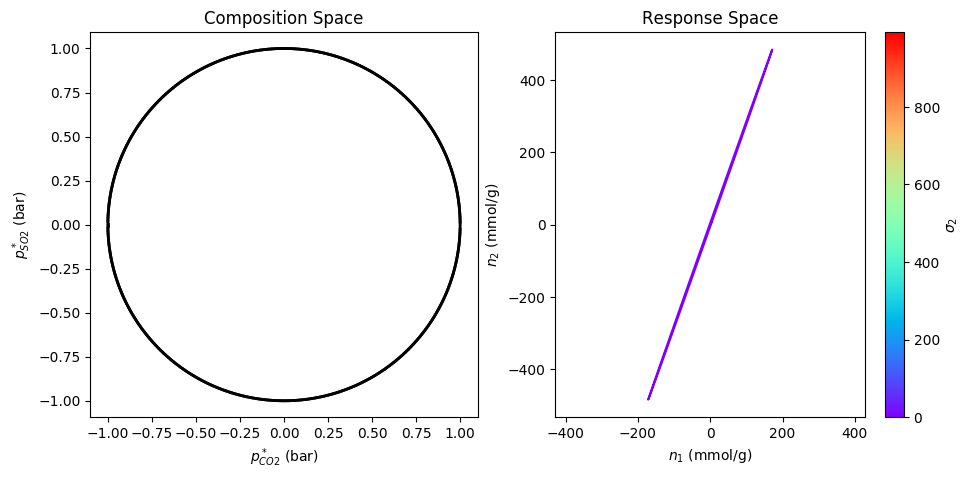

Condition number for 10 - 11: 305.120696


PyObject Text(945.531,0.5,'$ \\sigma_2 $')

In [15]:
plot_all_responses("CO2", "SO2", [10,11], CN_limit=Inf)

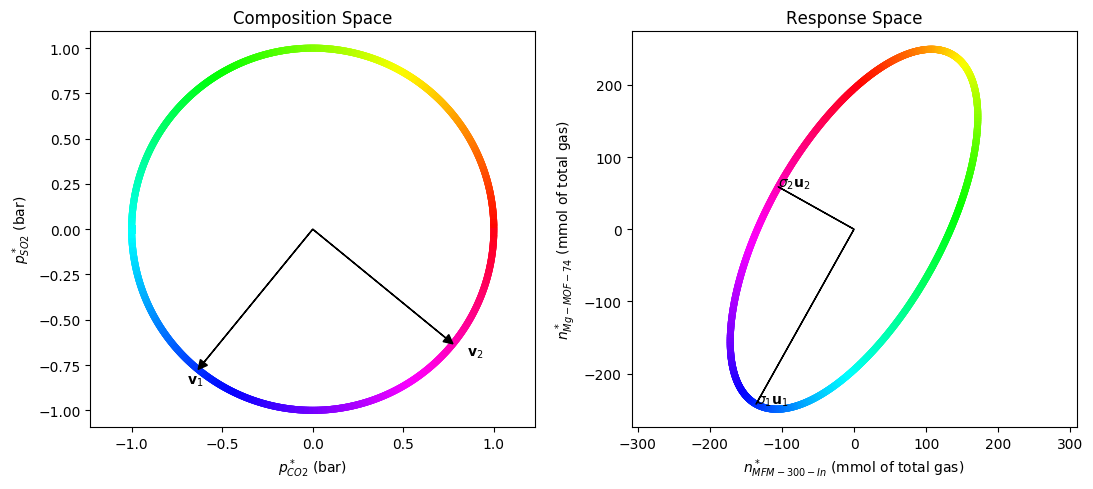

In [16]:
plot_response(11, 13, "CO2", "SO2")

In [17]:
sigma = perform_svd("SO2", "CO2")
analyze_svd(sigma)

The most sensitive pair of MOFs is SIFSIX-3-Ni and SIFSIX-2-Cu-i
The least sensitive pair of MOFs is Zn-CN6 and Co-CN6


In [18]:
#@testset "Sensor Tests" begin
#    H = make_h_matrix(3, 5, "CO2", "C2H6")
#    G = [(8.91e-5) (4.84e-5); (1.87e-5) (4.68e-5)] .- [5.84e-6; 9.56e-6]
#    @test isapprox(H, G)
#end

In [19]:
#@testset "MOF to index test" begin
#    @test isapprox(mof2index("MIL-101"), 2)
#end

# Lets Try another Idea!

In [20]:
function plot_rectangle3(gas1::AbstractString, gas2::AbstractString, l_gas1::Float64, l_gas2::Float64, index_list::Union{Array{Int64, 1}, Missing}=missing)
    n_pts = 15
    wid = range(0, stop=l_gas1, length=n_pts)
    len = range(0, stop=l_gas2, length=n_pts)
    grid_a = [i for i in wid, j in len]
    grid_b = [j for i in wid, j in len]
    p = transpose([grid_a[:] grid_b[:]])
    corners = [0.0 l_gas1 l_gas1 0.0;
               0.0 0.0 l_gas2 l_gas2]
    print(size(corners))
    figure(figsize=(11, 5))
    subplot(121)
    
    for i = 1:n_pts
        plot([0, wid[end]], [len[i], len[i]], color="k")
        plot([wid[i], wid[i]], [0, len[end]], color="k")
    end
    scatter(corners[1,1], corners[2,1], color="r")
    scatter(corners[1,2], corners[2,2], color="b")
    scatter(corners[1,3], corners[2,3], color="g")
    scatter(corners[1,4], corners[2,4], color="c")
    #scatter(p[1,:], p[2,:], s=3)
    #axis("equal")
    xlim([-0.1*maximum(p[1,:]), maximum(p[1,:]*1.1)])
    ylim([-0.1*maximum(p[2,:]), maximum(p[2,:]*1.1)])
    title("Composition Space")
    xlabel(@sprintf("\$p_{%s}\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}\$ (bar)", gas2))
    xticks(rotation=45)
    ax = subplot(122)
    #axis("equal")
    
    if index_list !== missing
        number_of_mofs = length(index_list)
        if number_of_mofs < 2
            @error "Need more than one index to plot the response!"
        end
        pairs = combinations(index_list, 2)
    else
        number_of_mofs = size(df_henry)[1]
        pairs = combinations(1:number_of_mofs, 2)
    end
    title(@sprintf("Response Space"))
    xlabel(@sprintf("\$n_1\$ (mmol/g)"))
    ylabel(@sprintf("\$n_2\$ (mmol/g)"))

    for (k, pair) in enumerate(pairs)
        mof1 = df_henry[pair[1], :crystal]
        mof2 = df_henry[pair[2], :crystal]
        label = @sprintf("%s and %s", mof1, mof2)
        H = make_h_matrix(pair[1], pair[2], gas1, gas2)
        F = svd(H)
        new_corners = H * corners
        #n = H * p
        #scatter(n[1,:], n[2,:], s=3)
        for i = 1:n_pts
            coords = [0.0 wid[end] wid[i] wid[i];
                    len[i] len[i] 0.0 len[end]]
            h = H * coords
            h1 = [h[1,1], h[1,2]]
            h2 = [h[2,1], h[2,2]]
            h3 = [h[1,3], h[1,4]]
            h4 = [h[2,3], h[2,4]]    
            plot(h1, h2, color="k")
            plot(h3, h4, color="k")
        end
        scatter(new_corners[1,1], new_corners[2,1], color="r")
        scatter(new_corners[1,2], new_corners[2,2], color="b")
        scatter(new_corners[1,3], new_corners[2,3], color="g")
        scatter(new_corners[1,4], new_corners[2,4], color="c")

            
        #xlim([-0.1*maximum(n[1,:]), maximum(n[1,:]*1.1)])
        #ylim([-0.1*maximum(n[2,:]), maximum(n[2,:]*1.1)])
    end
end
    
plot_rectangle3(gas1::AbstractString, gas2::AbstractString, l_gas1::Float64, l_gas2::Float64, mof_list::Array{String, 1}) = plot_rectangle(gas1, gas2, l_gas1, l_gas2, mof2index.(mof_list))

plot_rectangle3 (generic function with 3 methods)

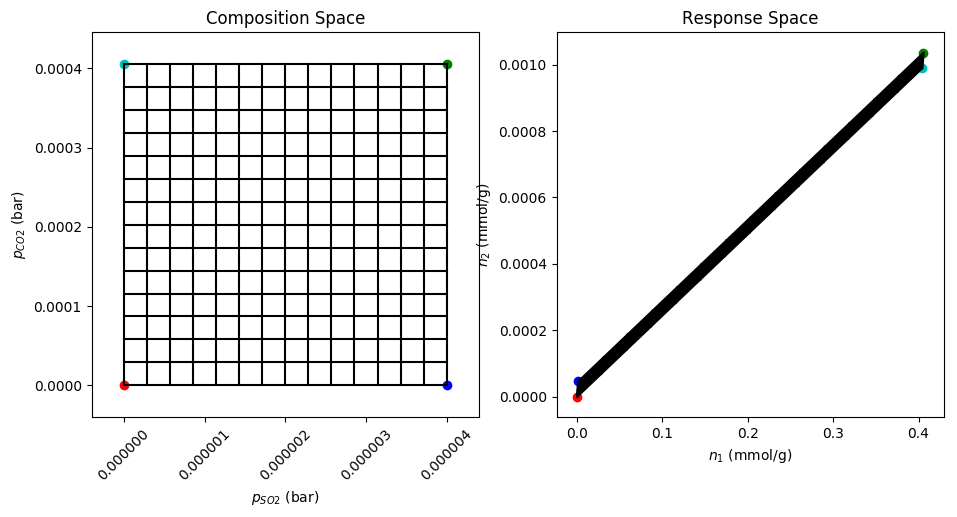

(2, 4)

In [21]:
plot_rectangle3("SO2", "CO2", 4.0/1e6, 405.0/1e6, [2,14])